In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

# Constants
P = 113  # Modulo value
VOCAB_SIZE = P + 1  # Numbers from 0 to 112, plus "=" token
EQUAL_TOKEN = P  # Assign "=" token the index P
SEQ_LEN = 3  # "a b ="

class ModAddDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs  # Shape: (num_samples, seq_len)
        self.targets = targets  # Shape: (num_samples,)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]  # Sequence of token indices
        y = self.targets[idx]  # Target value
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# Generate all possible pairs (a, b)
all_pairs = [(a, b) for a in range(P) for b in range(P)]
total_pairs = len(all_pairs)
print(f"Total possible pairs: {total_pairs}")

# Assign indices to "=" token
equal_token_idx = EQUAL_TOKEN

# Create all possible input sequences and targets
all_inputs = []
all_targets = []
for a, b in all_pairs:
    input_seq = [a, b, equal_token_idx]
    target = (a + b) % P
    all_inputs.append(input_seq)
    all_targets.append(target)

all_inputs = np.array(all_inputs)
all_targets = np.array(all_targets)

def train_and_evaluate(seed, num_epochs=20000, noise_std=0.1):
    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Shuffle the data
    indices = np.arange(total_pairs)
    np.random.shuffle(indices)
    shuffled_inputs = all_inputs[indices]
    shuffled_targets = all_targets[indices]

    # Split into training and test sets (30% for training)
    train_size = int(0.3 * total_pairs)
    train_inputs = shuffled_inputs[:train_size]
    train_targets = shuffled_targets[:train_size]
    test_inputs = shuffled_inputs[train_size:]
    test_targets = shuffled_targets[train_size:]

    print(f"Seed {seed}: Training samples: {len(train_inputs)}, Test samples: {len(test_inputs)}")

    # Create Dataset objects
    train_dataset = ModAddDataset(train_inputs, train_targets)
    test_dataset = ModAddDataset(test_inputs, test_targets)

    # Data loaders (full batch gradient descent)
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    # Define the model
    class SimpleTransformer(nn.Module):
        def __init__(self, vocab_size, seq_len, d_model, num_heads, dim_feedforward, dropout=0.0):
            super(SimpleTransformer, self).__init__()
            self.d_model = d_model

            # Token and positional embeddings
            self.token_embed = nn.Embedding(vocab_size, d_model)
            self.pos_embed = nn.Parameter(torch.zeros(seq_len, d_model))

            # Transformer Encoder Layer
            self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout)
            self.fc1 = nn.Linear(d_model, dim_feedforward)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(dim_feedforward, d_model)

            # Output layer (unembedding)
            self.fc_out = nn.Linear(d_model, vocab_size)

        def forward(self, src, noise_std=0.0):
            # src shape: (batch_size, seq_len)
            batch_size, seq_len = src.size()

            # Token embedding
            token_embeddings = self.token_embed(src)  # (batch_size, seq_len, d_model)

            # Add positional embeddings
            embeddings = token_embeddings + self.pos_embed  # (batch_size, seq_len, d_model)

            # Add Gaussian noise to embeddings if noise_std > 0
            if noise_std > 0.0:
                noise = torch.randn_like(embeddings[:, :2, :]) * noise_std
                embeddings[:, :2, :] = embeddings[:, :2, :] + noise

            # Prepare for multihead attention: (seq_len, batch_size, d_model)
            embeddings = embeddings.transpose(0, 1)

            # Self-attention
            attn_output, _ = self.attention(embeddings, embeddings, embeddings)
            attn_output = attn_output.transpose(0, 1)  # (batch_size, seq_len, d_model)

            # MLP
            x = self.fc1(attn_output)  # (batch_size, seq_len, dim_feedforward)
            x = self.relu(x)
            x = self.fc2(x)  # (batch_size, seq_len, d_model)

            # Read output above "=" token (last token)
            output_token = x[:, -1, :]  # (batch_size, d_model)

            # Output logits
            logits = self.fc_out(output_token)  # (batch_size, vocab_size)

            return logits

    # Model parameters
    d_model = 128
    num_heads = 4
    dim_feedforward = 512
    dropout = 0.0  # No dropout as per description

    # Instantiate the model
    model = SimpleTransformer(
        vocab_size=VOCAB_SIZE,
        seq_len=SEQ_LEN,
        d_model=d_model,
        num_heads=num_heads,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    )

    # Move model to device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer (AdamW with weight decay parameter λ = 1)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1.0)

    # Training loop
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    sensitivities = []
    weight_norms = []  # List to store weight norms

    for epoch in range(1, num_epochs + 1):
        # Training
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)  # (batch_size, vocab_size)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Record training loss and accuracy
        train_losses.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y_batch).sum().item()
        accuracy = correct / y_batch.size(0)
        train_accuracies.append(accuracy)

        # Sensitivity calculation on training data
        model.eval()
        with torch.no_grad():
            # Original predictions
            outputs_clean = model(x_batch)
            _, predicted_clean = torch.max(outputs_clean.data, 1)

            # Predictions with corrupted embeddings
            outputs_noisy = model(x_batch, noise_std=noise_std)
            _, predicted_noisy = torch.max(outputs_noisy.data, 1)

            # Calculate sensitivity
            changed_predictions = (predicted_clean != predicted_noisy).sum().item()
            sensitivity = changed_predictions / y_batch.size(0)
            sensitivities.append(sensitivity)

        # Compute and record the norm of the model's weights
        total_norm = 0.0
        for param in model.parameters():
            param_norm = param.data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        weight_norms.append(total_norm)

        # Evaluation on test set every 100 epochs
        if epoch % 100 == 0 or epoch == 1:
            with torch.no_grad():
                for x_test, y_test in test_loader:
                    x_test = x_test.to(device)
                    y_test = y_test.to(device)
                    outputs_test = model(x_test)
                    test_loss = criterion(outputs_test, y_test)
                    _, predicted_test = torch.max(outputs_test.data, 1)
                    correct_test = (predicted_test == y_test).sum().item()
                    test_accuracy = correct_test / y_test.size(0)
                    test_losses.append(test_loss.item())
                    test_accuracies.append(test_accuracy)

            print(f"Seed {seed}, Epoch {epoch}/{num_epochs}, "
                  f"Train Loss: {loss.item():.4f}, Train Acc: {accuracy*100:.2f}%, "
                  f"Test Loss: {test_loss.item():.4f}, Test Acc: {test_accuracy*100:.2f}%, "
                  f"Sensitivity: {sensitivity*100:.2f}%, "
                  f"Weight Norm: {total_norm:.4f}")

    # Convert recorded values to numpy arrays
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    train_accuracies = np.array(train_accuracies)
    test_accuracies = np.array(test_accuracies)
    sensitivities = np.array(sensitivities)
    weight_norms = np.array(weight_norms)

    # Return metrics
    return train_losses, test_losses, train_accuracies, test_accuracies, sensitivities, weight_norms

# Run training and evaluation for different random seeds
num_runs = 5
seeds = [42, 43, 44]
num_epochs = 17000
noise_std = 0.1

# Initialize lists to store metrics for all runs
all_train_losses = []
all_test_losses = []
all_train_accuracies = []
all_test_accuracies = []
all_sensitivities = []
all_weight_norms = []

for seed in seeds:
    (train_losses, test_losses, train_accuracies, test_accuracies,
     sensitivities, weight_norms) = train_and_evaluate(
        seed, num_epochs=num_epochs, noise_std=noise_std)
    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)
    all_train_accuracies.append(train_accuracies)
    all_test_accuracies.append(test_accuracies)
    all_sensitivities.append(sensitivities)
    all_weight_norms.append(weight_norms)

# Plotting the metrics
x = num_epochs

# Epochs where test evaluation was performed
test_epochs = np.arange(1, x + 1)[(np.arange(x) + 1) % 100 == 0]
if 1 not in test_epochs:
    test_epochs = np.insert(test_epochs, 0, 1)

epochs = np.arange(1, x + 1)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

num_runs = 3

# Smoothing function (rolling average with window size)
def smooth_curve(data, window_size=50):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean()

# Train Loss Plot
plt.figure(figsize=(8, 4))
for i in range(num_runs):
    smoothed_train_losses = smooth_curve(all_train_losses[i])
    plt.plot(epochs, smoothed_train_losses, label=f'Seed {i+1}')
plt.axvline(x=500, color='r', linestyle='--', label='Epoch 500')
plt.axvline(x=8100, color='b', linestyle='--', label='Epoch 8100')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Test Loss Plot
plt.figure(figsize=(8, 4))
for i in range(num_runs):
    smoothed_test_losses = smooth_curve(all_test_losses[i])
    plt.plot(test_epochs, smoothed_test_losses, label=f'Seed {i+1}')
plt.axvline(x=500, color='r', linestyle='--', label='Epoch 500')
plt.axvline(x=8100, color='b', linestyle='--', label='Epoch 8100')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Train Accuracy Plot
plt.figure(figsize=(8, 4))
for i in range(num_runs):
    smoothed_train_accuracies = smooth_curve(all_train_accuracies[i])
    plt.plot(epochs, smoothed_train_accuracies, label=f'Seed {i+1}')
plt.axvline(x=500, color='r', linestyle='--', label='Epoch 500')
plt.axvline(x=8100, color='b', linestyle='--', label='Epoch 8100')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Test Accuracy Plot
plt.figure(figsize=(8, 4))
for i in range(num_runs):
    smoothed_test_accuracies = smooth_curve(all_test_accuracies[i])
    plt.plot(test_epochs, smoothed_test_accuracies, label=f'Seed {i+1}')
plt.axvline(x=500, color='r', linestyle='--', label='Epoch 500')
plt.axvline(x=8100, color='b', linestyle='--', label='Epoch 8100')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Sensitivity Plot
plt.figure(figsize=(8, 4))
for i in range(num_runs):
    smoothed_sensitivities = smooth_curve(all_sensitivities[i]) * 100
    plt.plot(epochs, smoothed_sensitivities, label=f'Seed {i+1}')
plt.axvline(x=500, color='r', linestyle='--', label='Epoch 500')
plt.axvline(x=8100, color='b', linestyle='--', label='Epoch 8100')
plt.xlabel('Epoch')
plt.ylabel('Sensitivity (%)')
plt.title('Sensitivity over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Weight Norm Plot
plt.figure(figsize=(8,4))
for i in range(num_runs):
    smoothed_weight_norms = smooth_curve(all_weight_norms[i])
    plt.plot(epochs, smoothed_weight_norms, label=f'Seed {i+1}')
plt.axvline(x=500, color='r', linestyle='--', label='Epoch 500')
plt.axvline(x=8100, color='b', linestyle='--', label='Epoch 8100')
plt.xlabel('Epoch')
plt.ylabel('Weight Norm')
plt.title('Weight Norm over Epochs')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'all_train_losses' is not defined

<Figure size 800x400 with 0 Axes>

In [5]:
import torch

# Assuming the .pt file is stored in the path 'grokking_results/grokking_results_metrics.pt'
# Load the .pt file
save_path = "grokking_results/grokking_results_metrics.pt"

# Loading the saved data
loaded_data = torch.load(save_path)

# Extract the tensors from the loaded data
loaded_train_losses = loaded_data['train_losses']
loaded_test_losses = loaded_data['test_losses']
loaded_train_accuracies = loaded_data['train_accuracies']
loaded_test_accuracies = loaded_data['test_accuracies']
loaded_sensitivities = loaded_data['sensitivities']
loaded_weight_norms = loaded_data['weight_norms']

# Displaying the loaded data to confirm
loaded_data.keys()


dict_keys(['train_losses', 'test_losses', 'train_accuracies', 'test_accuracies', 'sensitivities', 'weight_norms'])

In [16]:
smoothed_train_losses

0        4.739575e+00
1        4.735073e+00
2        4.730742e+00
3        4.726283e+00
4        4.721591e+00
             ...     
16995    4.213267e-07
16996    4.212090e-07
16997    4.210895e-07
16998    4.209569e-07
16999    4.208349e-07
Length: 17000, dtype: float64

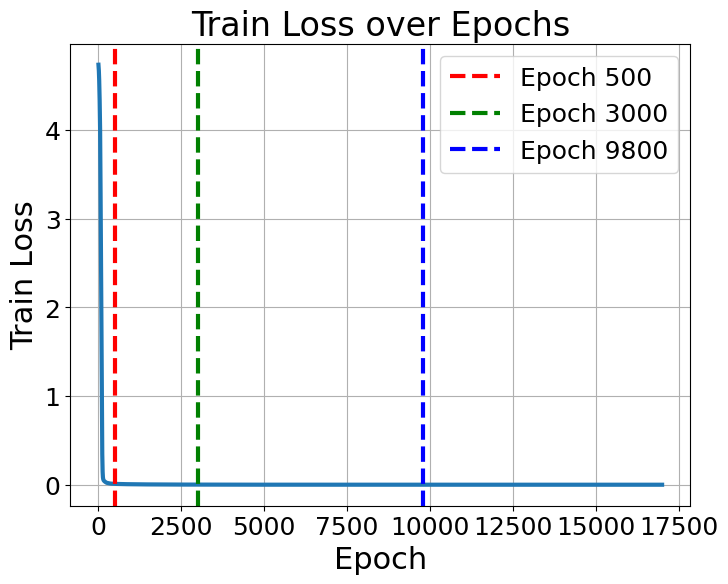

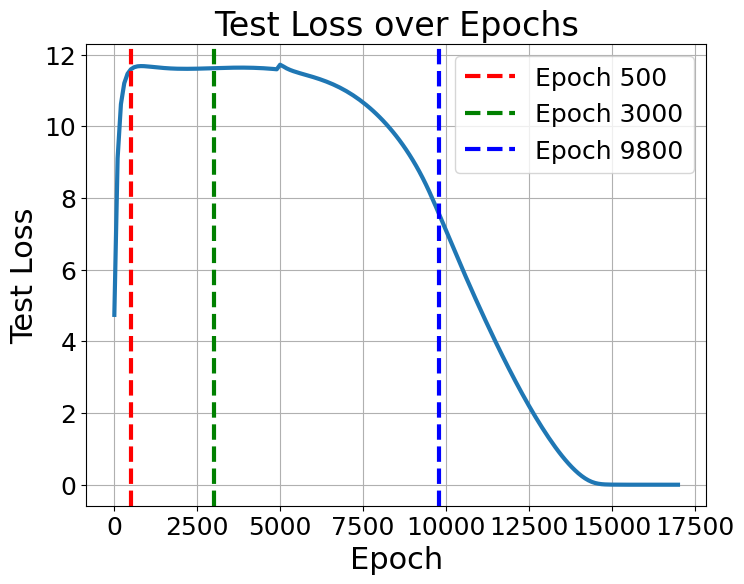

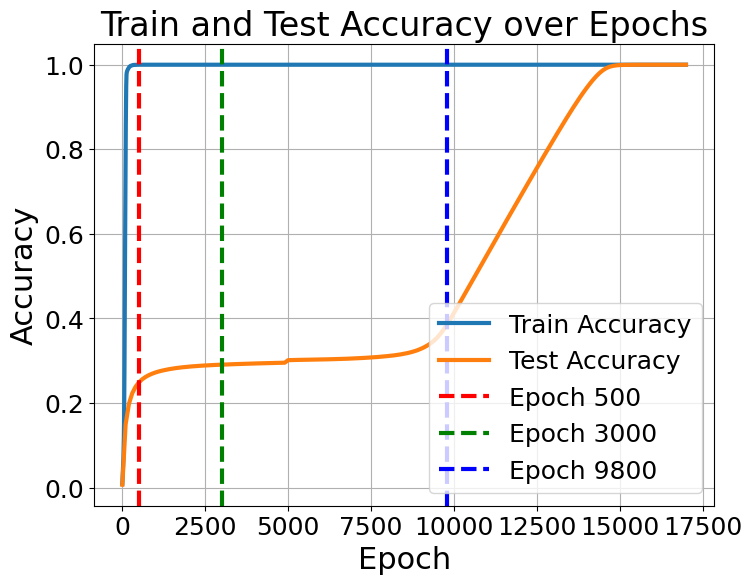

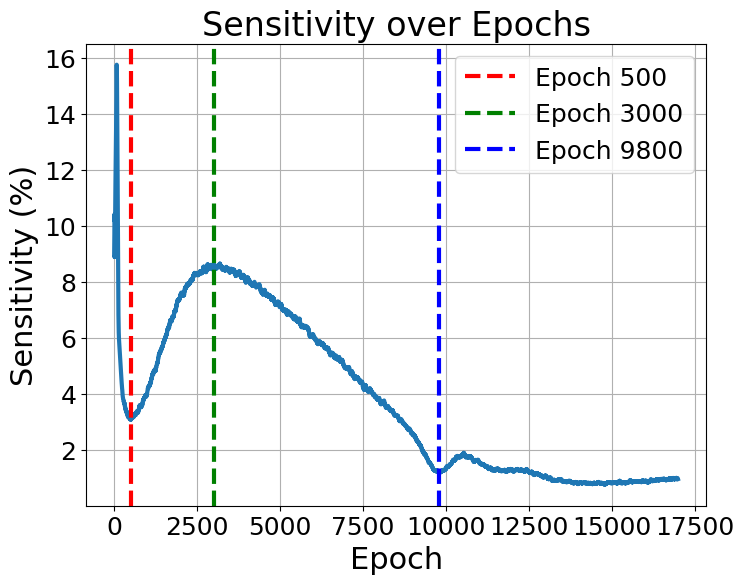

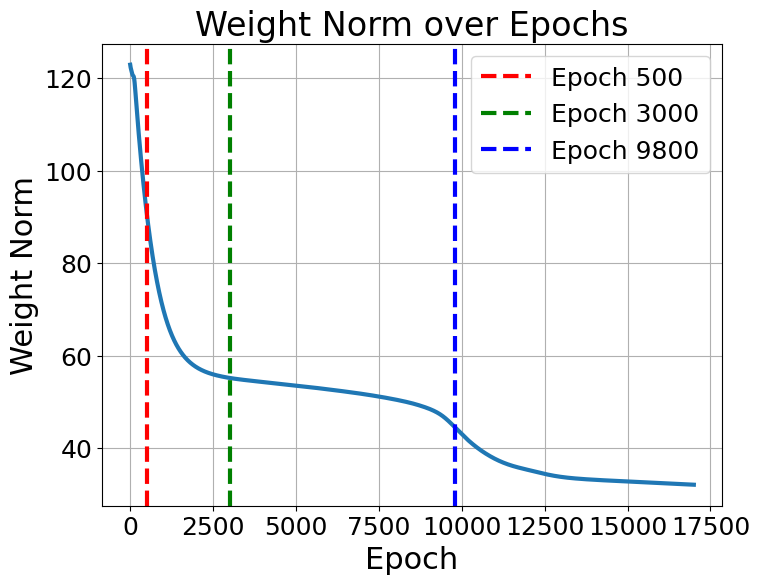

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming that the variables have been loaded from the .pt file:
all_train_losses = loaded_train_losses[0].tolist()
all_test_losses = loaded_test_losses[0].tolist()
all_train_accuracies = loaded_train_accuracies[0].tolist()
all_test_accuracies = loaded_test_accuracies[0].tolist()
all_sensitivities = loaded_sensitivities[0].tolist()
all_weight_norms = loaded_weight_norms[0].tolist()

# Generate epochs array with the same length as your data
epochs = np.arange(len(all_train_losses))

# Plotting the metrics
x = len(all_train_losses)

# Epochs where test evaluation was performed
test_epochs = np.arange(1, x + 1)[(np.arange(x) + 1) % 100 == 0]
if 1 not in test_epochs:
    test_epochs = np.insert(test_epochs, 0, 1)

epochs = np.arange(1, x + 1)

# Smoothing function (rolling average with window size)
def smooth_curve(data, window_size=50):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean()

# Increase font size for plots
plt.rcParams.update({'font.size': 18})  # Further increase font size

# Train Loss Plot (First Run)
plt.figure(figsize=(8, 6))
smoothed_train_losses = smooth_curve(all_train_losses)  # First run only
plt.plot(epochs, smoothed_train_losses, linewidth=3)  # Line width = 3
plt.axvline(x=500, color='r', linestyle='--', linewidth=3, label='Epoch 500')  # Thicker vertical lines
plt.axvline(x=3000, color='g', linestyle='--', linewidth=3, label='Epoch 3000')
plt.axvline(x=9800, color='b', linestyle='--', linewidth=3, label='Epoch 9800')
plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Train Loss', fontsize=22)
plt.title('Train Loss over Epochs', fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

# Test Loss Plot (First Run)
plt.figure(figsize=(8, 6))
smoothed_test_losses = smooth_curve(all_test_losses)  # First run only
plt.plot(test_epochs, smoothed_test_losses, linewidth=3)  # Line width = 3
plt.axvline(x=500, color='r', linestyle='--', linewidth=3, label='Epoch 500')  # Thicker vertical lines
plt.axvline(x=3000, color='g', linestyle='--', linewidth=3, label='Epoch 3000')
plt.axvline(x=9800, color='b', linestyle='--', linewidth=3, label='Epoch 9800')
plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Test Loss', fontsize=22)
plt.title('Test Loss over Epochs', fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

# Train and Test Accuracy Plot (Combined)
plt.figure(figsize=(8, 6))
smoothed_train_accuracies = smooth_curve(all_train_accuracies)  # First run only
smoothed_test_accuracies = smooth_curve(all_test_accuracies)  # First run only
plt.plot(epochs, smoothed_train_accuracies, label='Train Accuracy', linewidth=3)  # Line width = 3
plt.plot(test_epochs, smoothed_test_accuracies, label='Test Accuracy', linewidth=3)  # Line width = 3
plt.axvline(x=500, color='r', linestyle='--', linewidth=3, label='Epoch 500')  # Thicker vertical lines
plt.axvline(x=3000, color='g', linestyle='--', linewidth=3, label='Epoch 3000')
plt.axvline(x=9800, color='b', linestyle='--', linewidth=3, label='Epoch 9800')
plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
plt.title('Train and Test Accuracy over Epochs', fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

# Sensitivity Plot (First Run)
plt.figure(figsize=(8, 6))
smoothed_sensitivities = smooth_curve(all_sensitivities) * 100  # First run only
plt.plot(epochs, smoothed_sensitivities, linewidth=3)  # Line width = 3
plt.axvline(x=500, color='r', linestyle='--', linewidth=3, label='Epoch 500')  # Thicker vertical lines
plt.axvline(x=3000, color='g', linestyle='--', linewidth=3, label='Epoch 3000')
plt.axvline(x=9800, color='b', linestyle='--', linewidth=3, label='Epoch 9800')
plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Sensitivity (%)', fontsize=22)
plt.title('Sensitivity over Epochs', fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

# Weight Norm Plot (First Run)
plt.figure(figsize=(8, 6))
smoothed_weight_norms = smooth_curve(all_weight_norms)  # First run only
plt.plot(epochs, smoothed_weight_norms, linewidth=3)  # Line width = 3
plt.axvline(x=500, color='r', linestyle='--', linewidth=3, label='Epoch 500')  # Thicker vertical lines
plt.axvline(x=3000, color='g', linestyle='--', linewidth=3, label='Epoch 3000')
plt.axvline(x=9800, color='b', linestyle='--', linewidth=3, label='Epoch 9800')
plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Weight Norm', fontsize=22)
plt.title('Weight Norm over Epochs', fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()


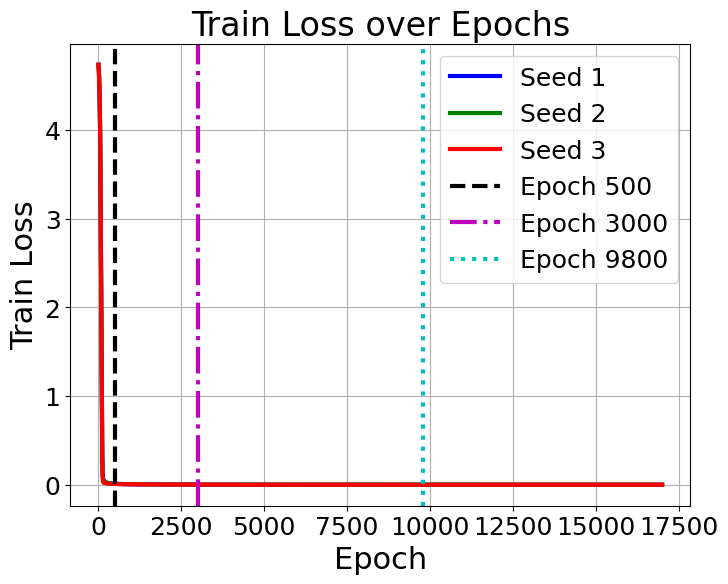

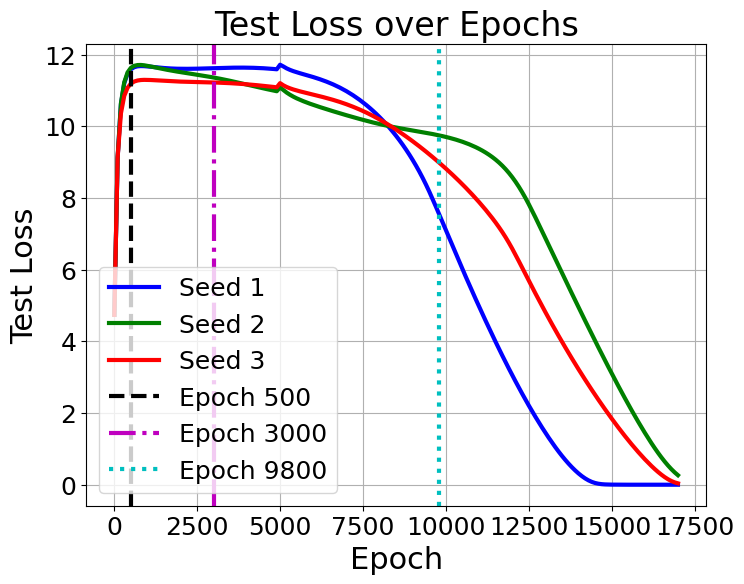

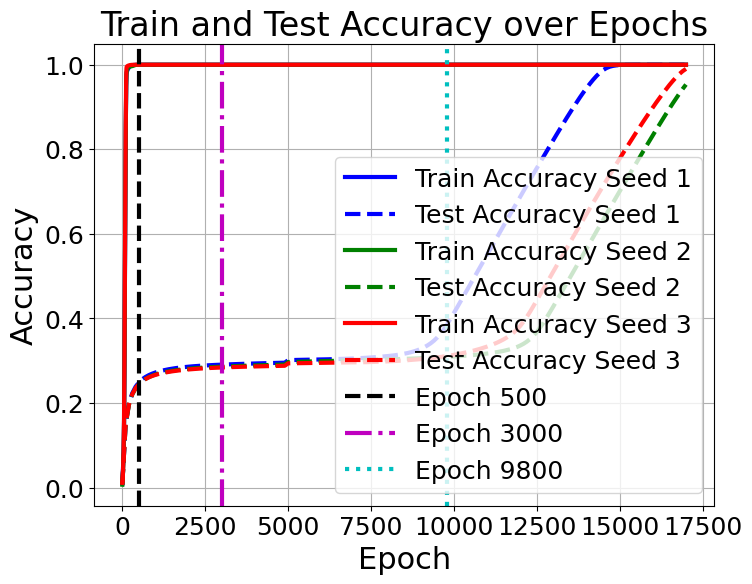

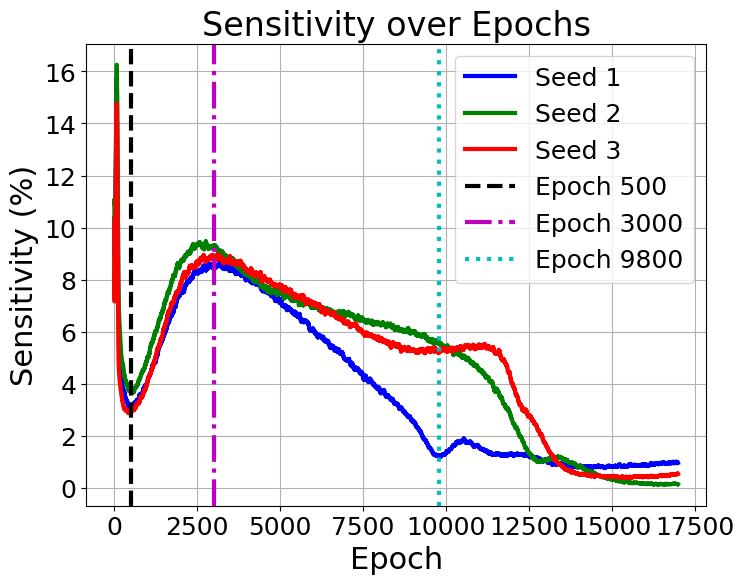

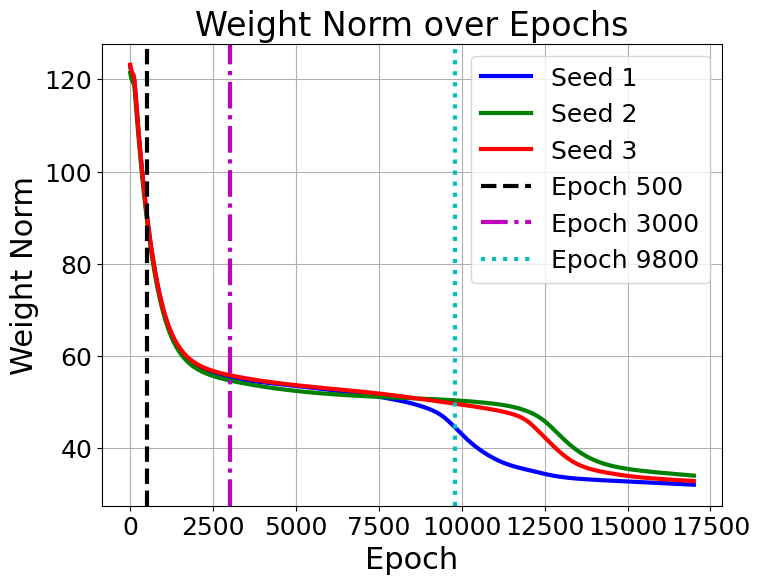

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming the variables have been loaded from the .pt file, where each has 3 runs (first dimension: [0, 1, 2])
# Convert the tensor data to lists
all_train_losses = [loaded_train_losses[i].tolist() for i in range(3)]
all_test_losses = [loaded_test_losses[i].tolist() for i in range(3)]
all_train_accuracies = [loaded_train_accuracies[i].tolist() for i in range(3)]
all_test_accuracies = [loaded_test_accuracies[i].tolist() for i in range(3)]
all_sensitivities = [loaded_sensitivities[i].tolist() for i in range(3)]
all_weight_norms = [loaded_weight_norms[i].tolist() for i in range(3)]

# Generate epochs array with the same length as your data
epochs = np.arange(len(all_train_losses[0]))

# Plotting the metrics
x = len(all_train_losses[0])

# Epochs where test evaluation was performed
test_epochs = np.arange(1, x + 1)[(np.arange(x) + 1) % 100 == 0]
if 1 not in test_epochs:
    test_epochs = np.insert(test_epochs, 0, 1)

epochs = np.arange(1, x + 1)

# Smoothing function (rolling average with window size)
def smooth_curve(data, window_size=50):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean()

# Colors for the different runs
colors = ['b', 'g', 'r']

# Increase font size for plots
plt.rcParams.update({'font.size': 18})

# Train Loss Plot (All Runs)
plt.figure(figsize=(8, 6))
for i in range(3):
    smoothed_train_losses = smooth_curve(all_train_losses[i])
    plt.plot(epochs, smoothed_train_losses, linewidth=3, label=f'Seed {i+1}', color=colors[i])

# Different vertical lines with distinct styles
plt.axvline(x=500, color='k', linestyle='--', linewidth=3, label='Epoch 500')
plt.axvline(x=3000, color='m', linestyle='-.', linewidth=3, label='Epoch 3000')
plt.axvline(x=9800, color='c', linestyle=':', linewidth=3, label='Epoch 9800')

plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Train Loss', fontsize=22)
plt.title('Train Loss over Epochs', fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

# Test Loss Plot (All Runs)
plt.figure(figsize=(8, 6))
for i in range(3):
    smoothed_test_losses = smooth_curve(all_test_losses[i])
    plt.plot(test_epochs, smoothed_test_losses, linewidth=3, label=f'Seed {i+1}', color=colors[i])

# Different vertical lines with distinct styles
plt.axvline(x=500, color='k', linestyle='--', linewidth=3, label='Epoch 500')
plt.axvline(x=3000, color='m', linestyle='-.', linewidth=3, label='Epoch 3000')
plt.axvline(x=9800, color='c', linestyle=':', linewidth=3, label='Epoch 9800')

plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Test Loss', fontsize=22)
plt.title('Test Loss over Epochs', fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

# Train and Test Accuracy Plot (Combined for All Runs)
plt.figure(figsize=(8, 6))
for i in range(3):
    smoothed_train_accuracies = smooth_curve(all_train_accuracies[i])
    smoothed_test_accuracies = smooth_curve(all_test_accuracies[i])
    plt.plot(epochs, smoothed_train_accuracies, linewidth=3, label=f'Train Accuracy Seed {i+1}', color=colors[i])
    plt.plot(test_epochs, smoothed_test_accuracies, linewidth=3, label=f'Test Accuracy Seed {i+1}', linestyle='--', color=colors[i])

# Different vertical lines with distinct styles
plt.axvline(x=500, color='k', linestyle='--', linewidth=3, label='Epoch 500')
plt.axvline(x=3000, color='m', linestyle='-.', linewidth=3, label='Epoch 3000')
plt.axvline(x=9800, color='c', linestyle=':', linewidth=3, label='Epoch 9800')

plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
plt.title('Train and Test Accuracy over Epochs', fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

# Sensitivity Plot (All Runs)
plt.figure(figsize=(8, 6))
for i in range(3):
    smoothed_sensitivities = smooth_curve(all_sensitivities[i]) * 100
    plt.plot(epochs, smoothed_sensitivities, linewidth=3, label=f'Seed {i+1}', color=colors[i])

# Different vertical lines with distinct styles
plt.axvline(x=500, color='k', linestyle='--', linewidth=3, label='Epoch 500')
plt.axvline(x=3000, color='m', linestyle='-.', linewidth=3, label='Epoch 3000')
plt.axvline(x=9800, color='c', linestyle=':', linewidth=3, label='Epoch 9800')

plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Sensitivity (%)', fontsize=22)
plt.title('Sensitivity over Epochs', fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

# Weight Norm Plot (All Runs)
plt.figure(figsize=(8, 6))
for i in range(3):
    smoothed_weight_norms = smooth_curve(all_weight_norms[i])
    plt.plot(epochs, smoothed_weight_norms, linewidth=3, label=f'Seed {i+1}', color=colors[i])

# Different vertical lines with distinct styles
plt.axvline(x=500, color='k', linestyle='--', linewidth=3, label='Epoch 500')
plt.axvline(x=3000, color='m', linestyle='-.', linewidth=3, label='Epoch 3000')
plt.axvline(x=9800, color='c', linestyle=':', linewidth=3, label='Epoch 9800')

plt.xlabel('Epoch', fontsize=22)
plt.ylabel('Weight Norm', fontsize=22)
plt.title('Weight Norm over Epochs', fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()
